In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/online+retail/Online Retail.xlsx"

df = pd.read_excel(file_path)
print("Rows, Columns =", df.shape)
df.head()

Rows, Columns = (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Remove missing customers
df = df.dropna(subset=["CustomerID"])

# Remove cancelled invoices
df = df[~df["InvoiceNo"].astype(str).str.startswith("C", na=False)]

# Keep only positive quantity & price
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Create revenue column
df["LineTotal"] = df["Quantity"] * df["UnitPrice"]

# Ensure datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Reference date for RFM
reference_date = df["InvoiceDate"].max() + timedelta(days=1)

# Reset index
df = df.reset_index(drop=True)

print("Rows after cleaning:", len(df))
print("Unique customers:", df["CustomerID"].nunique())
print("Date range:", df["InvoiceDate"].min(), "to", df["InvoiceDate"].max())


Rows after cleaning: 397884
Unique customers: 4338
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (reference_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("LineTotal", "sum")
).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
# Log-transform skewed RFM features
rfm["Recency_log"] = np.log1p(rfm["Recency"])
rfm["Frequency_log"] = np.log1p(rfm["Frequency"])
rfm["Monetary_log"] = np.log1p(rfm["Monetary"])

# Feature matrix for clustering
X = rfm[["Recency_log", "Frequency_log", "Monetary_log"]]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
results = []

for k in range(2, 8):

    # K-Means++
    km = KMeans(n_clusters=k, init="k-means++", random_state=42)
    km_labels = km.fit_predict(X_scaled)
    results.append(("KMeans++", k,
                    silhouette_score(X_scaled, km_labels),
                    davies_bouldin_score(X_scaled, km_labels)))

    # Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    results.append(("GMM", k,
                    silhouette_score(X_scaled, gmm_labels),
                    davies_bouldin_score(X_scaled, gmm_labels)))

    # Bisecting K-Means
    bkm = BisectingKMeans(n_clusters=k, random_state=42)
    bkm_labels = bkm.fit_predict(X_scaled)
    results.append(("BisectingKMeans", k,
                    silhouette_score(X_scaled, bkm_labels),
                    davies_bouldin_score(X_scaled, bkm_labels)))

results_df = pd.DataFrame(
    results,
    columns=["Model", "k", "Silhouette", "DaviesBouldin"]
).sort_values("Silhouette", ascending=False)

results_df

,Model,k,Silhouette,DaviesBouldin
0,KMeans++,2,0.433193,0.891481
2,BisectingKMeans,2,0.433193,0.891481
5,BisectingKMeans,3,0.356895,1.007129
6,KMeans++,4,0.337134,1.010147
3,KMeans++,3,0.336013,1.049222
9,KMeans++,5,0.317312,0.988205
12,KMeans++,6,0.314270,1.019979
15,KMeans++,7,0.287479,1.030789
1,GMM,2,0.285566,1.066716
8,BisectingKMeans,4,0.282098,1.173209


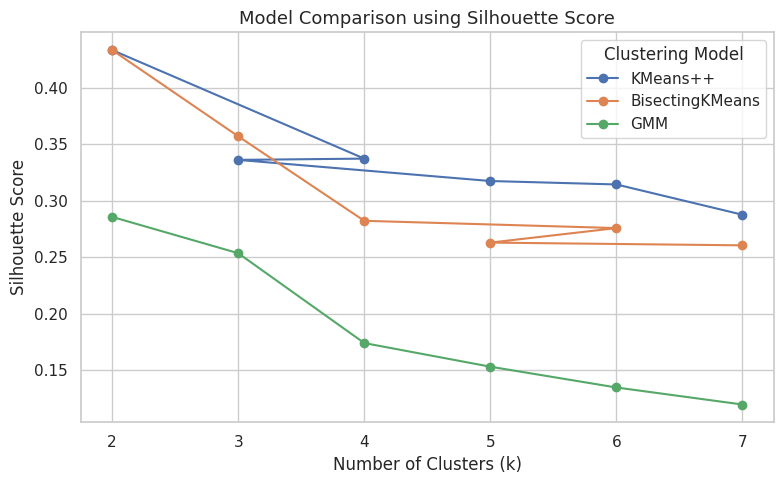

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure clean style
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# Plot Silhouette score vs k for each model
for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"] == model]
    plt.plot(
        subset["k"],
        subset["Silhouette"],
        marker="o",
        label=model
    )

plt.title("Model Comparison using Silhouette Score", fontsize=13)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend(title="Clustering Model")
plt.tight_layout()

# Save for paper / presentation
plt.savefig("model_comparison_silhouette.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# We fix k = 3 to ensure stable, interpretable clusters
best_k = 3
print("Using fixed k =", best_k)

final_model = KMeans(
    n_clusters=best_k,
    init="k-means++",
    random_state=42
)

# Assign cluster labels
rfm["Cluster"] = final_model.fit_predict(X_scaled)

# ---- Internal cluster validation (for paper) ----
silhouette = silhouette_score(X_scaled, rfm["Cluster"])
print("Silhouette Score:", round(silhouette, 3))

# Store cluster centers (for later early-warning analysis)
cluster_centers = final_model.cluster_centers_

# Cluster sizes
cluster_sizes = rfm["Cluster"].value_counts().sort_index()
cluster_sizes

Using fixed k = 3
Silhouette Score: 0.336


,count
Cluster,
0,1696
1,776
2,1866


In [ ]:
# Cluster profiling
cluster_profile = (
    rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .sort_values("Monetary", ascending=False)
)
cluster_profile

,Recency,Frequency,Monetary
Cluster,,,
1,17.070876,13.274485,7865.636662
0,44.463443,3.368514,1257.688940
2,167.613076,1.349411,361.539877


In [ ]:
# Semantic labels (DATA-DRIVEN, FINAL)

cluster_order = (
    cluster_profile
    .sort_values("Monetary", ascending=False)
    .index
    .tolist()
)

semantic_map = {
    cluster_order[0]: "High-Value",
    cluster_order[1]: "Mid-Value",
    cluster_order[2]: "Low-Value"
}

rfm["Segment"] = rfm["Cluster"].map(semantic_map)

semantic_map

{1: 'High-Value', 0: 'Mid-Value', 2: 'Low-Value'}

In [ ]:
cluster_distribution_df = (
    rfm["Segment"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

cluster_distribution_df.columns = ["Segment", "Proportion (%)"]
cluster_distribution_df

,Segment,Proportion (%)
0,Low-Value,43.02
1,Mid-Value,39.10
2,High-Value,17.89


In [ ]:
cluster_summary = rfm.groupby("Cluster").agg(
    Customers=("CustomerID", "count"),
    Avg_Recency=("Recency", "mean"),
    Avg_Frequency=("Frequency", "mean"),
    Avg_Monetary=("Monetary", "mean")
)

# Percentage of customers in each cluster
cluster_summary["Customer_%"] = (
    cluster_summary["Customers"] /
    cluster_summary["Customers"].sum()
) * 100

# Sort clusters by value
cluster_summary = cluster_summary.sort_values("Avg_Monetary", ascending=False)

# Round values for clean presentation
cluster_summary = cluster_summary.round(2)

cluster_summary

,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_%
Cluster,,,,,
1,776,17.07,13.27,7865.64,17.89
0,1696,44.46,3.37,1257.69,39.10
2,1866,167.61,1.35,361.54,43.02


In [ ]:
# Identify which cluster is high-value
high_value_cluster = cluster_summary.sort_values("Avg_Monetary", ascending=False).index[0]
print("High-value cluster =", high_value_cluster)

# Subset only high-value customers
high_value_customers = rfm[rfm["Cluster"] == high_value_cluster]

print("Number of high-value customers:", len(high_value_customers))
high_value_customers.head()

High-value cluster = 1
Number of high-value customers: 776


,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Cluster,Segment
1,12347.0,2,7,4310.00,1.098612,2.079442,8.368925,1,High-Value
5,12352.0,36,8,2506.04,3.610918,2.197225,7.826858,1,High-Value
15,12362.0,3,10,5226.23,1.386294,2.397895,8.561637,1,High-Value
30,12381.0,5,5,1845.31,1.791759,1.791759,7.520944,1,High-Value
34,12388.0,16,6,2780.66,2.833213,1.945910,7.930803,1,High-Value


In [ ]:
high_value_customers.to_csv("high_value_customers.csv", index=False)

In [ ]:
# Create Year-Month column
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

# Define month-end reference date for recency
df["MonthEnd"] = df["YearMonth"].dt.to_timestamp("M")

# Monthly RFM per customer
monthly_rfm = df.groupby(["CustomerID", "YearMonth"]).agg(
    Recency=("InvoiceDate",
             lambda x: (x.max().to_period("M")
                        .to_timestamp("M") - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("LineTotal", "sum")
).reset_index()

# Keep only high-value customers
hv_monthly = monthly_rfm[
    monthly_rfm["CustomerID"].isin(high_value_customers["CustomerID"])
]

# Sort for proper temporal analysis
hv_monthly = hv_monthly.sort_values(["CustomerID", "YearMonth"])

hv_monthly.head()

,CustomerID,YearMonth,Recency,Frequency,Monetary
1,12347.0,2010-12,23,1,711.79
2,12347.0,2011-01,4,1,475.39
3,12347.0,2011-04,22,1,636.25
4,12347.0,2011-06,20,1,382.52
5,12347.0,2011-08,28,1,584.91


In [ ]:
def detect_warning(group):
    group = group.sort_values("YearMonth")

    group["Freq_Change"] = group["Frequency"].diff()
    group["Mon_Change"] = group["Monetary"].diff()
    group["Rec_Change"] = group["Recency"].diff()

    # 2-of-3 decline rule
    group["Warning_Flag"] = (
        ((group["Freq_Change"] < 0) & (group["Mon_Change"] < 0)) |
        ((group["Mon_Change"] < 0) & (group["Rec_Change"] > 0)) |
        ((group["Freq_Change"] < 0) & (group["Rec_Change"] > 0))
    )

    return group


warnings_df = (
    hv_monthly
    .drop(columns=["CustomerID"])
    .groupby(hv_monthly["CustomerID"], sort=False)
    .apply(detect_warning)
    .reset_index()
)

warnings_df.head()

,CustomerID,level_1,YearMonth,Recency,Frequency,Monetary,Freq_Change,Mon_Change,Rec_Change,Warning_Flag
0,12347.0,1,2010-12,23,1,711.79,NaN,NaN,NaN,False
1,12347.0,2,2011-01,4,1,475.39,0.0,-236.40,-19.0,False
2,12347.0,3,2011-04,22,1,636.25,0.0,160.86,18.0,False
3,12347.0,4,2011-06,20,1,382.52,0.0,-253.73,-2.0,False
4,12347.0,5,2011-08,28,1,584.91,0.0,202.39,8.0,False


In [ ]:
early_warning_customers = warnings_df[warnings_df["Warning_Flag"] == True][
    ["CustomerID","YearMonth","Frequency","Monetary","Recency"]
]

print("Total early-warning signals:", len(early_warning_customers))

early_warning_customers = early_warning_customers.sort_values(
    ["CustomerID", "YearMonth"]
)
early_warning_customers.head()

Total early-warning signals: 1917


,CustomerID,YearMonth,Frequency,Monetary,Recency
6,12347.0,2011-12,1,224.82,23
9,12352.0,2011-09,2,632.50,1
10,12352.0,2011-11,1,311.73,26
13,12362.0,2011-07,1,303.76,23
17,12362.0,2011-11,1,477.94,25


In [ ]:
# Count number of warning months per customer
warning_counts = (
    warnings_df
    .groupby("CustomerID")["Warning_Flag"]
    .sum()
    .reset_index(name="Warning_Count")
)

# Define Early Risk label (>=2 warning months)
warning_counts["Early_Risk"] = (
    warning_counts["Warning_Count"] >= 2
).astype(int)

warning_counts.head()

,CustomerID,Warning_Count,Early_Risk
0,12347.0,1,0
1,12352.0,2,1
2,12362.0,2,1
3,12381.0,2,1
4,12388.0,2,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


# Merge RFM + Cluster + Segment with Early Risk label
ml_df = rfm.merge(
    warning_counts[["CustomerID", "Early_Risk"]],
    on="CustomerID",
    how="inner"
)

# Select features for ML
feature_cols = [
    "Recency_log",
    "Frequency_log",
    "Monetary_log",
    "Cluster"
]

X = ml_df[feature_cols]
y = ml_df["Early_Risk"]

print("ML dataset shape:", X.shape)
print("Positive class ratio:", y.mean())

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

#Train Random Forest

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

#Evaluation

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", round(auc, 3))

#Feature Importance

feature_importance = (
    pd.Series(rf_model.feature_importances_, index=feature_cols)
    .sort_values(ascending=False)
)

feature_importance

ML dataset shape: (776, 4)
Positive class ratio: 0.7087628865979382

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.54      0.53        57
           1       0.81      0.79      0.80       137

    accuracy                           0.72       194
   macro avg       0.66      0.67      0.66       194
weighted avg       0.72      0.72      0.72       194

ROC-AUC Score: 0.788


,0
Frequency_log,0.511591
Monetary_log,0.284893
Recency_log,0.203516
Cluster,0.000000


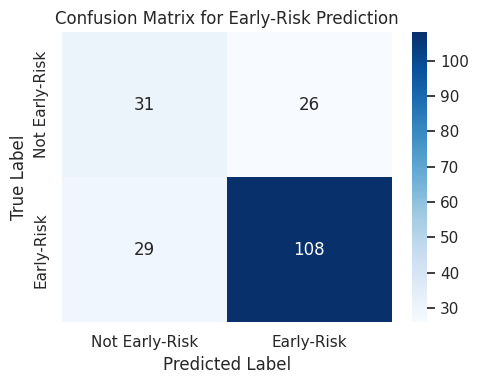

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Early-Risk", "Early-Risk"],
    yticklabels=["Not Early-Risk", "Early-Risk"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Early-Risk Prediction")
plt.tight_layout()
plt.show()

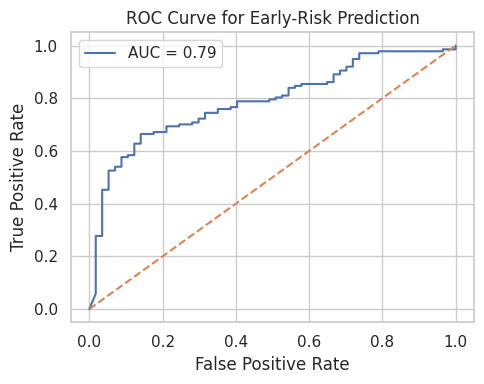

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Early-Risk Prediction")
plt.legend()
plt.tight_layout()
plt.show()

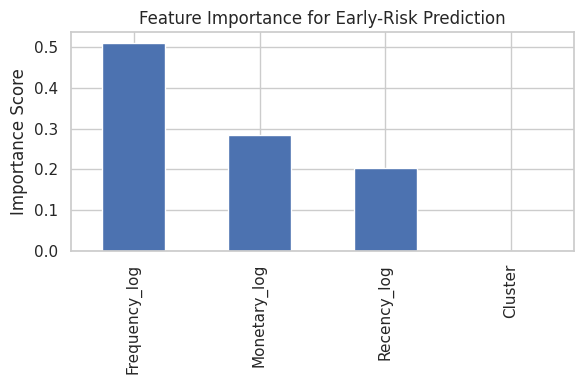

In [ ]:
plt.figure(figsize=(6, 4))
feature_importance.plot(kind="bar")
plt.ylabel("Importance Score")
plt.title("Feature Importance for Early-Risk Prediction")
plt.tight_layout()
plt.show()